In [3]:
from dotenv import load_dotenv

import os

import pandas as pd
from openai import OpenAI

In [11]:
load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_KEY

In [12]:
client = OpenAI()

In [13]:
model_lst = openai.models
print(model_lst.list())

SyncPage[Model](data=[Model(id='gpt-3.5-turbo-0301', created=1677649963, object='model', owned_by='openai'), Model(id='dall-e-3', created=1698785189, object='model', owned_by='system'), Model(id='dall-e-2', created=1698798177, object='model', owned_by='system'), Model(id='whisper-1', created=1677532384, object='model', owned_by='openai-internal'), Model(id='gpt-3.5-turbo-0125', created=1706048358, object='model', owned_by='system'), Model(id='text-embedding-ada-002', created=1671217299, object='model', owned_by='openai-internal'), Model(id='tts-1-hd-1106', created=1699053533, object='model', owned_by='system'), Model(id='tts-1-hd', created=1699046015, object='model', owned_by='system'), Model(id='davinci-002', created=1692634301, object='model', owned_by='system'), Model(id='babbage-002', created=1692634615, object='model', owned_by='system'), Model(id='text-embedding-3-small', created=1705948997, object='model', owned_by='system'), Model(id='gpt-3.5-turbo-16k-0613', created=1685474247

In [4]:
# dump the list in text file
with open("model_list.txt", "w") as f:
    f.write(str(model_lst.list()))

In [14]:
df = pd.read_csv("/Users/Yasser/Projects/masters_thesis/Master_Thesis/data/argument_relation_class.csv")
df

,text,label
0,"In fact as I said, a lot of the Azure use case...",1
1,"So we continue to build for high AFN, or Amazo...",1
2,"On tech and content, that's going to be a comb...",0
3,And what you'll see is that basically people u...,0
4,Our goal really is to kick-start an ecosystem ...,0
...,...,...
9793,I actually think over the next couple of years...,0
9794,"That said, I don't think it’s growing as fast ...",1
9795,So I think you do see some interplay there on ...,1
9796,"There they're really two key dynamics, the fir...",1


In [15]:
# map labels 1 to Related and 0 to Unrelated
df["label"] = df["label"].map({1: "Related", 0: "Unrelated"})
df

,text,label
0,"In fact as I said, a lot of the Azure use case...",Related
1,"So we continue to build for high AFN, or Amazo...",Related
2,"On tech and content, that's going to be a comb...",Unrelated
3,And what you'll see is that basically people u...,Unrelated
4,Our goal really is to kick-start an ecosystem ...,Unrelated
...,...,...
9793,I actually think over the next couple of years...,Unrelated
9794,"That said, I don't think it’s growing as fast ...",Related
9795,So I think you do see some interplay there on ...,Related
9796,"There they're really two key dynamics, the fir...",Related


In [16]:
# Generate 2 cols by split text column into claim and permise, please note separator is [SEP] then remove [SEP] from premise
df[["claim", "premise"]] = df["text"].str.split("\[SEP\]", n=1, expand=True)
df

,text,label,claim,premise
0,"In fact as I said, a lot of the Azure use case...",Related,"In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...
1,"So we continue to build for high AFN, or Amazo...",Related,"So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...
2,"On tech and content, that's going to be a comb...",Unrelated,"On tech and content, that's going to be a comb...",We're continuing to build the products that a...
3,And what you'll see is that basically people u...,Unrelated,And what you'll see is that basically people u...,because the best of the people creating those...
4,Our goal really is to kick-start an ecosystem ...,Unrelated,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries..."
...,...,...,...,...
9793,I actually think over the next couple of years...,Unrelated,I actually think over the next couple of years...,We certainly have additional delivery capabil...
9794,"That said, I don't think it’s growing as fast ...",Related,"That said, I don't think it’s growing as fast ...","I mean, you really can't tell the difference,..."
9795,So I think you do see some interplay there on ...,Related,So I think you do see some interplay there on ...,"That means more time in video, and that does ..."
9796,"There they're really two key dynamics, the fir...",Related,"There they're really two key dynamics, the fir...",The component that actually has impacted -- t...


In [98]:
sample = df.sample(3)
sample

,text,label,claim,premise
9004,And while we don't expect these changes will s...,Unrelated,And while we don't expect these changes will s...,"Well, one of the things that I’ve been focuse..."
7914,But the thing that – the first question that K...,Related,But the thing that – the first question that K...,So at least the vision that we have is that e...
7020,It was a good quarter for that. [SEP] We also ...,Unrelated,It was a good quarter for that.,We also think that there's a real competitive...


## Modelling

In [101]:
#TODO: Create a function to generate the messages for argument clause relation classification by explaining the task and providing the claim and premise as this:

def generate_messages(claim, premise):
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Given the following claim and premise, please classify the relation between them as either Related or Unrelated. Please only generate one of the two labels."},
        {"role": "user", "content": f"Claim: {claim}"},
        {"role": "user", "content": f"Premise: {premise}"},
    ]
    return messages

In [103]:
function = {
   "name": "predict_premise_claim_relation",
   "description": "Predict the relation between a claim and a premise.",
   "parameters": {
       "type": "object",
       "properties": {
           "prediction": {
               "type": "array",
               "items": {
                   "type": "string",
                   "enum": [
                       "Related",
                       "Unrelated"
                   ]
               },
               "description": "The predicted relation between the claim and the premise."
           }
       },
       "required": [
           "prediction"
       ]
   }
}

In [104]:
#TODO: Use the generated prompt to generate the completion using openai's GPT-4 model, please use chat completions
def generate_completions(messages, model="gpt-4"):
    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        functions=[function],
        temperature=0.0,
        seed=42,
    )
    return completion


In [120]:
#TODO: Use the generated completion to predict the relation between the claim and the premise    
def predict_relation(claim, premise, model="gpt-4"):
    try:
        prompt = generate_messages(claim, premise)
        completion = generate_completions(prompt, model)
        print(completion.choices[0].message.content)
        return (completion.choices[0].message.content, completion)
    except Exception as e:
        print(e)
        return ("Unrelated", completion)
    

### Dangerous Don't Run!!!

In [121]:
#TODO: Use the predict_relation function to predict the relation between the claim and the premise for the sample then generate a column in df called predicted_relation and completion_object
df["predicted_relation"], df["completion_object"] = zip(*df.apply(lambda x: predict_relation(x["claim"], x["premise"]), axis=1))

Related
None
Unrelated
Unrelated
Unrelated
Related
Related
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
Related
Unrelated
Unrelated
Unrelated
Related
Unrelated
None
Unrelated
Unrelated
Unrelated
None
Related
Related
Related
Related
Related
Related
Unrelated
Unrelated
None
Unrelated
Unrelated
Unrelated
None
Related
Unrelated
Unrelated
Related
Related
Unrelated
Related
Unrelated
Unrelated
Unrelated
Unrelated
None
Related
None
Related
Unrelated
None
Unrelated
Related
None
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
Unrelated
None
Related
None
Unrelated
Related
Unrelated
None
Related
Related
Unrelated
Related
Unrelated
Related
None
Unrelated
Related
Related
Unrelated
Unrelated
None
None
None
Unrelated
Unrelated
Unrelated
Related
Related
Related
Related
Related
Unrelated
None
Related
None
Unrelated
Related
Related
None
Related
Unrelated
Unrelated
Related
Unrelated
Unrelated
Unrelated
None
Related
Related
Unrelated
None
Related
Unrelated
None
None
Unrelated
Rel

In [122]:
df.head()

,text,label,claim,premise,predicted_relation,completion_object
0,"In fact as I said, a lot of the Azure use case...",Related,"In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...,Related,ChatCompletion(id='chatcmpl-8oZjGLE69SWWIBmbwx...
1,"So we continue to build for high AFN, or Amazo...",Related,"So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...,None,ChatCompletion(id='chatcmpl-8oZjH8upLekufi7eia...
2,"On tech and content, that's going to be a comb...",Unrelated,"On tech and content, that's going to be a comb...",We're continuing to build the products that a...,Unrelated,ChatCompletion(id='chatcmpl-8oZjIoWMXFljpz0szh...
3,And what you'll see is that basically people u...,Unrelated,And what you'll see is that basically people u...,because the best of the people creating those...,Unrelated,ChatCompletion(id='chatcmpl-8oZjJKWgfQ4Xn3DbP8...
4,Our goal really is to kick-start an ecosystem ...,Unrelated,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries...",Unrelated,ChatCompletion(id='chatcmpl-8oZjKU0cxdV2QyjvEa...


In [123]:
# save the sample to a csv file
df.to_csv("temp_0_seed_42_gpt_4_zero_shot_classification.csv", index=False)

In [124]:
#TODO: report Marco F1 score, precision, recall, and accuracy and the confusion matrix then save them in a text file
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def report_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred, labels=["Related", "Unrelated"])
    return report, confusion


In [17]:
import pandas as pd

df = pd.read_csv("temp_0_seed_42_gpt_4_zero_shot_classification.csv")
df

,text,label,claim,premise,predicted_relation,completion_object
0,"In fact as I said, a lot of the Azure use case...",Related,"In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...,Related,ChatCompletion(id='chatcmpl-8oZjGLE69SWWIBmbwx...
1,"So we continue to build for high AFN, or Amazo...",Related,"So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...,NaN,ChatCompletion(id='chatcmpl-8oZjH8upLekufi7eia...
2,"On tech and content, that's going to be a comb...",Unrelated,"On tech and content, that's going to be a comb...",We're continuing to build the products that a...,Unrelated,ChatCompletion(id='chatcmpl-8oZjIoWMXFljpz0szh...
3,And what you'll see is that basically people u...,Unrelated,And what you'll see is that basically people u...,because the best of the people creating those...,Unrelated,ChatCompletion(id='chatcmpl-8oZjJKWgfQ4Xn3DbP8...
4,Our goal really is to kick-start an ecosystem ...,Unrelated,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries...",Unrelated,ChatCompletion(id='chatcmpl-8oZjKU0cxdV2QyjvEa...
...,...,...,...,...,...,...
9793,I actually think over the next couple of years...,Unrelated,I actually think over the next couple of years...,We certainly have additional delivery capabil...,Unrelated,ChatCompletion(id='chatcmpl-8ocHs72g8zRNDHQf5Q...
9794,"That said, I don't think it’s growing as fast ...",Related,"That said, I don't think it’s growing as fast ...","I mean, you really can't tell the difference,...",Unrelated,ChatCompletion(id='chatcmpl-8ocHtfcmhKyZiUhWqd...
9795,So I think you do see some interplay there on ...,Related,So I think you do see some interplay there on ...,"That means more time in video, and that does ...",NaN,ChatCompletion(id='chatcmpl-8ocHt0gnBihOCIzOdj...
9796,"There they're really two key dynamics, the fir...",Related,"There they're really two key dynamics, the fir...",The component that actually has impacted -- t...,Unrelated,ChatCompletion(id='chatcmpl-8ocHvLqw74aZdBP5dO...


In [18]:
completion_objects = df["completion_object"]
completion_objects

0       ChatCompletion(id='chatcmpl-8oZjGLE69SWWIBmbwx...
1       ChatCompletion(id='chatcmpl-8oZjH8upLekufi7eia...
2       ChatCompletion(id='chatcmpl-8oZjIoWMXFljpz0szh...
3       ChatCompletion(id='chatcmpl-8oZjJKWgfQ4Xn3DbP8...
4       ChatCompletion(id='chatcmpl-8oZjKU0cxdV2QyjvEa...
                              ...                        
9793    ChatCompletion(id='chatcmpl-8ocHs72g8zRNDHQf5Q...
9794    ChatCompletion(id='chatcmpl-8ocHtfcmhKyZiUhWqd...
9795    ChatCompletion(id='chatcmpl-8ocHt0gnBihOCIzOdj...
9796    ChatCompletion(id='chatcmpl-8ocHvLqw74aZdBP5dO...
9797    ChatCompletion(id='chatcmpl-8ocHwhgfTYwJeO0CPS...
Name: completion_object, Length: 9798, dtype: object

In [23]:
# extract completion_tokens and prompt_tokens from str "ChatCompletion(id='chatcmpl-8oZjGLE69SWWIBmbwxEr1msYhyYQd', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Related', role='assistant', function_call=None, tool_calls=None))], created=1707064434, model='gpt-4-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=2, prompt_tokens=155, total_tokens=157))"
def extract_tokens(completion_object):
    completion_tokens = int(completion_object.split("completion_tokens=")[1].split(",")[0])
    prompt_tokens = int(completion_object.split("prompt_tokens=")[1].split(",")[0])
    return completion_tokens, prompt_tokens


df["completion_tokens"], df["prompt_tokens"] = zip(*completion_objects.apply(extract_tokens))

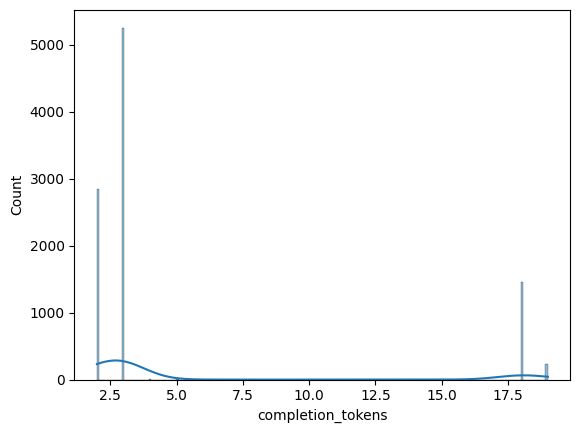

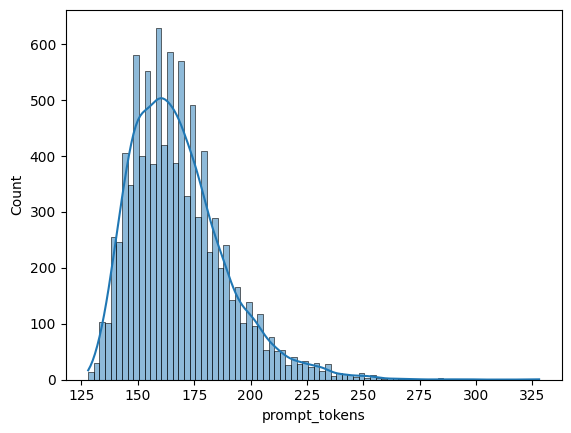

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# draw a distributation for completion_tokens and prompt_tokens
sns.histplot(df["completion_tokens"], kde=True)
plt.show()

sns.histplot(df["prompt_tokens"], kde=True)
plt.show()

In [27]:
# sum count the number of tokens in the completion and prompt and sum the counts
total_completion = df["completion_tokens"].sum()
total_prompt = df["prompt_tokens"].sum()
total_completion, total_prompt

(52053, 1645083)

In [28]:
cost = (0.06 * (total_completion/1000)) + (0.03 * (total_prompt/1000))
cost

52.47567

In [126]:
#TODO: Save the classification report and the confusion matrix in a text file

y_true = df["label"]
y_pred = df["predicted_relation"]

In [127]:
# map y_pred to Unrelated if the value is not Related or Unrelated
y_pred = y_pred.map(lambda x: "Unrelated" if x not in ["Related", "Unrelated"] else x)

              precision    recall  f1-score   support

     Related       0.80      0.47      0.59      4899
   Unrelated       0.62      0.89      0.73      4899

    accuracy                           0.68      9798
   macro avg       0.71      0.68      0.66      9798
weighted avg       0.71      0.68      0.66      9798





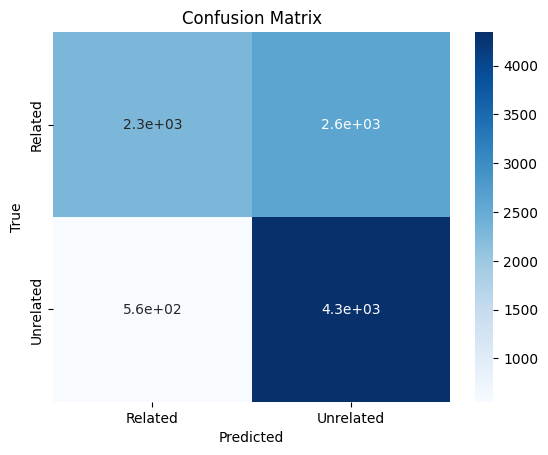

In [128]:
report, confusion = report_metrics(y_true, y_pred)
print(report)
print("\n")

# heatmap for confusion matrix and show classes and save it
sns.heatmap(confusion, annot=True, cmap="Blues", xticklabels=["Related", "Unrelated"], yticklabels=["Related", "Unrelated"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("temp_0_seed_42_gpt_4_zero_shot_classification_confusion_matrix.png")
plt.show()


In [ ]:
with open("temp_0_seed_42_gpt_4_zero_shot_classification_report.txt", "w") as f:
    f.write(report)